In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Error Propagation of Radon transform
Let $I \in \mathbb{N}^{r \times v}$ be a sinogram and the function $f: \mathbb{N}^{r \times v} \rightarrow \mathbb{N}^{n \times n}$ is the inverse radon transorm. Further be $F_x$ the Jacobian of $f$:
\begin{align}
    F_x &= \left[ \nabla f^T \right]^T &= \left[\begin{array}{c}
        f_1 \\
        \vdots \\
        f_{nn}
    \end{array}\right] \left[\begin{array}{ccc} \frac{\partial}{\partial I_1} & \dots & \frac{\partial}{\partial I_{rn}} \end{array}\right] &= \left[\begin{array}{ccc}
        \frac{\partial f_1}{\partial I_1} & \dots & \frac{\partial f_1}{\partial I_{rv}} \\
        \vdots & \ddots & \vdots \\
        \frac{\partial f_{nn}}{\partial I_1} & \dots & \frac{\partial f_{nn}}{\partial I_{rv}}
    \end{array}\right]
\end{align}

We now assume that $I$~$\mathcal{N}(\mu, \Sigma)$ is a realization of a multivariate normal distribution. The covariance matrix $\Sigma$ can be modelled in a way, that the correlation factor $\rho(i, j)$ is higher for columns $j$ and stays constant for rows $i$. We use exponential decay for the columns:
$$
    \rho(i) = exp( - \gamma i)
$$

The propagation of the uncertanty $\Sigma$ can be computed as followed:
$$
    \Sigma_f = F_x \Sigma F_x^T
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import tensorflow as tf
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print("CPUs Available: ", tf.config.list_physical_devices('CPU'))

import tensorflow_probability as tfp
from skimage import transform
from scipy.interpolate import interp1d
from error_propagation_radon_transform import utils

import importlib
importlib.reload(utils)

from ipywidgets import interact, widgets, interactive_output
from IPython.display import display

2023-02-07 12:14:13.202902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 12:14:18.259234: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-02-07 12:14:18.260201: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-02-07 12:14:18.260209: W tensorflow/c

GPUs Available:  []
CPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2023-02-07 12:14:27.127040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-02-07 12:14:27.127084: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
num_angle = 179
num_spotx = 162
num_offset = 1

wepl = np.load('../Data/simple_pCT/WEPL_angles179_offset1_spotx162.npy')

print(wepl.shape)
reconstruction_shape = (wepl.shape[0], wepl.shape[0])
print(reconstruction_shape)

(162, 179)
(162, 162)


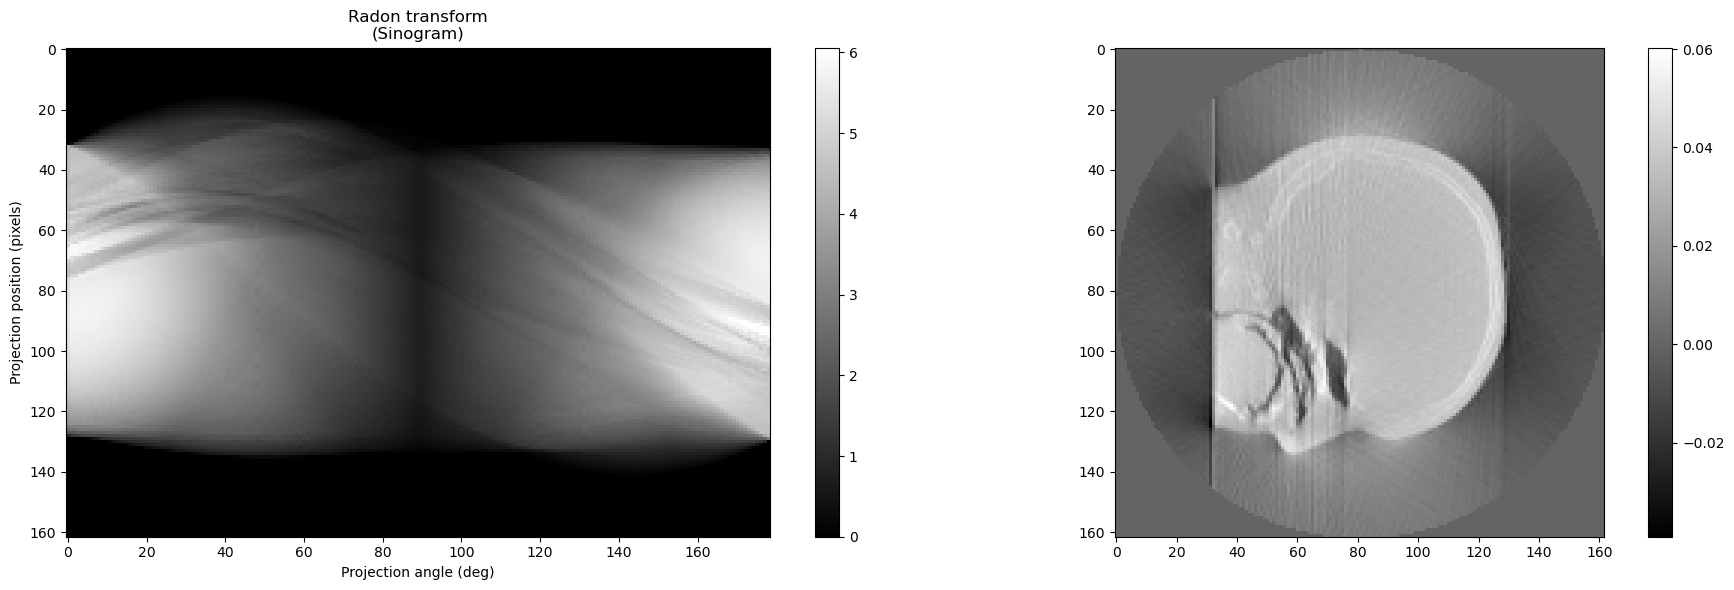

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

theta = np.linspace(0., 180., num_angle, endpoint=False)
ax1.set_title('Radon transform\n(Sinogram)')
ax1.set_xlabel('Projection angle (deg)')
ax1.set_ylabel('Projection position (pixels)')
sin = ax1.imshow(wepl, cmap='gray', aspect='auto')

plt.colorbar(sin, ax=ax1)

reconstructed = transform.iradon(wepl, theta=theta, filter_name='ramp')
re = ax2.imshow(reconstructed, cmap='gray')
plt.colorbar(re, ax=ax2)

fig.tight_layout()
plt.show()

In [5]:
filter_name = 'ramp'
width = 10
       
jacobian, reconstructed = utils.compute_gradient(wepl, theta, reconstruction_shape, filter_name)

var = np.ones_like(wepl) * 1053.7 # 5 % of sinogram value range
Sigma_in = utils.build_covariance_y(var, function=utils.exponential, width=width)

l,m,n,o = jacobian.shape
jacobian_reshaped = tf.reshape(jacobian, (l*m, n*o))

Sigma = jacobian_reshaped @ Sigma_in @ tf.transpose(jacobian_reshaped)

variance = tf.reshape(tf.abs(tf.linalg.tensor_diag_part(Sigma)), reconstruction_shape)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title('Sinogram')
plt.imshow(wepl, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(2,2,2)
plt.title('inverse Radon transform')
plt.imshow(reconstructed, cmap='gray')
plt.colorbar()

plt.subplot(2,2,3)
plt.title(r'$\Sigma$')
plt.imshow(Sigma_in)
plt.colorbar()

plt.subplot(2,2,4)
plt.title(r'$\sigma^2_f$')
plt.imshow(variance)
plt.colorbar()

plt.show()

2023-02-07 12:18:52.206012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
jacobian, kidney_reconstructed = utils.compute_gradient(sinogram, theta, kidney.shape, 'shepp-logan', None)
    
input_range = sinogram.max() - sinogram.min()
output_range = tf.reduce_max(kidney_reconstructed) - tf.reduce_min(kidney_reconstructed)
    
var = np.ones_like(sinogram) * 1053.7
Sigma_in = utils.build_covariance_y(var, function=exponential, width=5)

l,m,n,o = jacobian.shape
jacobian_reshaped = tf.reshape(jacobian, (l*m, n*o))

jacobian_reshaped_numpy = jacobian_reshaped.numpy()

Sigma = jacobian_reshaped_numpy @ Sigma_in @ tf.transpose(jacobian_reshaped_numpy)

64 64 64 160


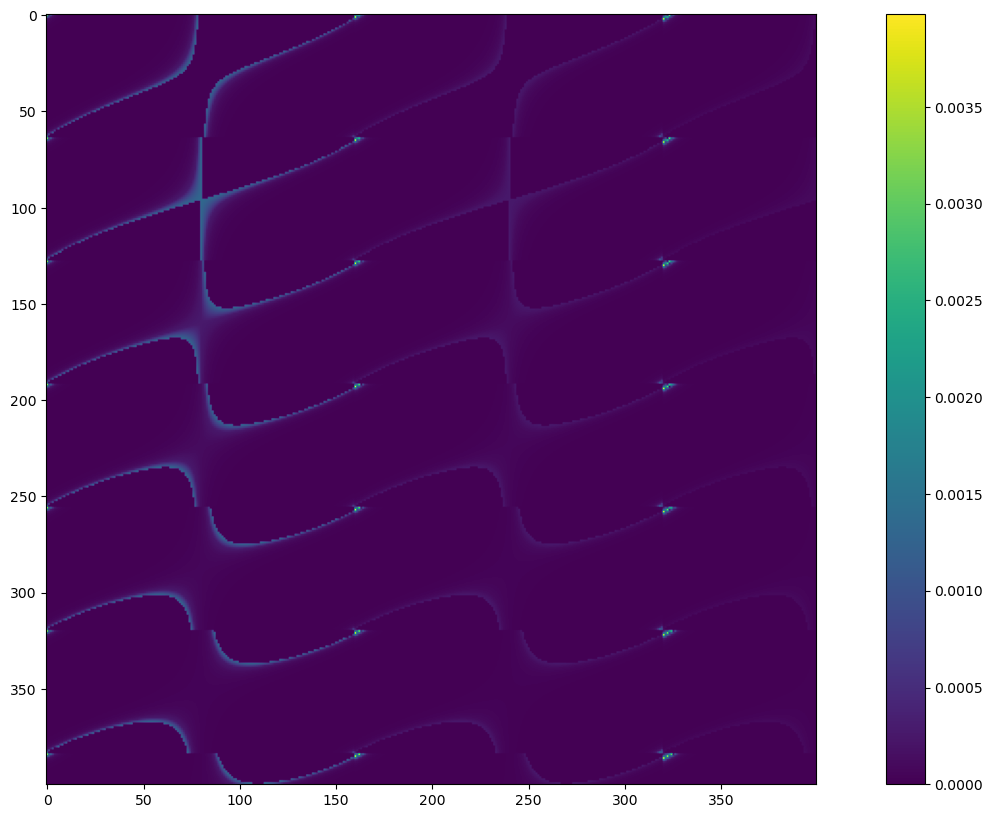

In [15]:
print(l,m,n,o)
plt.figure(figsize=(18,10))
plt.imshow(tf.math.abs(jacobian_reshaped_numpy[:400,:400]))
plt.colorbar()
plt.show()

In [16]:
@widgets.interact(phi=(0,sinogram.shape[0],1), t=(0,sinogram.shape[1],1))
def interact_imagespace(phi=0,t=0):
    plt.figure(figsize=(18,6))
    plt.imshow(tf.math.abs(jacobian[:,:,t,phi]))
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='phi', max=64), IntSlider(value=0, description='t', max=1…

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

In [17]:
@widgets.interact(x=(0,kidney_reconstructed.shape[0],1), y=(0,kidney_reconstructed.shape[1],1))
def interact_sinogramspace(x=0,y=0):
    plt.figure(figsize=(18,6))
    plt.imshow(tf.math.abs(jacobian[x,y,:,:]))
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='x', max=64), IntSlider(value=0, description='y', max=64)…

In [18]:
def plot_transform(x, y):
    variance = tf.reshape(tf.linalg.tensor_diag_part(Sigma), kidney_reconstructed.shape)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.title('reconstructed')
    plt.imshow(kidney_reconstructed, cmap='gray')
    plt.scatter(x, kidney_reconstructed.shape[1] - 1 - y, s=100)
    plt.subplot(1,3,2)
    plt.title(r'$real(\sigma^2)$')
    plt.imshow(tf.math.real(variance), cmap='gray')
    plt.colorbar()
    plt.scatter(x, kidney_reconstructed.shape[1] - 1 - y, s=100)
    plt.subplot(1,3,3)
    plt.title(r'$imag(\sigma^2)$')
    plt.imshow(tf.math.imag(variance), cmap='gray')
    plt.colorbar()
    plt.scatter(x, kidney_reconstructed.shape[1] - 1 - y, s=100)
    
    plt.show()
    
def plot_covar(x, y):
    y = kidney_reconstructed.shape[1] - 1 - y
    
    idx = kidney_reconstructed.shape[0] * y + x
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.title(r'$real(\Sigma)|_{xy}$')
    plt.imshow(tf.math.real(tf.reshape(Sigma[idx,:], kidney_reconstructed.shape)))
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.title(r'$imag(\Sigma)|_{xy}$')
    plt.imshow(tf.math.imag(tf.reshape(Sigma[idx,:], kidney_reconstructed.shape)))
    plt.colorbar()
    plt.show()

x_slider = widgets.IntSlider(32, 0, kidney_reconstructed.shape[0]-1, 1, description='x', layout=widgets.Layout(left='-60px', width='390px'))
y_slider = widgets.IntSlider(32, 0, kidney_reconstructed.shape[0]-1, 1, description='y', orientation='vertical', layout=widgets.Layout(top='-15px', height='290px'))

transform_ui = interactive_output(plot_transform, {
    'x': x_slider,
    'y': y_slider
})
covar_ui = interactive_output(plot_covar, {
    'x': x_slider,
    'y': y_slider
})

layout = widgets.HBox([
    y_slider,
    widgets.VBox([
        transform_ui,
        x_slider
    ])
])

display(widgets.VBox([
    layout,
    covar_ui
]))

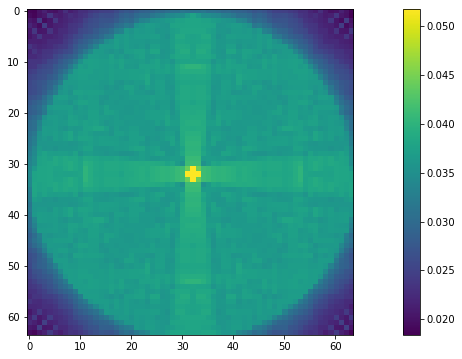

In [54]:
Sigma_cleaned = tf.math.real(Sigma).numpy()
for i in range(Sigma.shape[0]):
    Sigma_cleaned[i,i] = 0
summed = tf.reduce_max(tf.abs(tf.math.real(Sigma_cleaned)), axis=0)

plt.figure(figsize=(18,6))
plt.imshow(tf.reshape(summed, kidney_reconstructed.shape))
plt.colorbar()
plt.show()

In [9]:
print('jacobian:', np.prod([262144,524288]) * 8 / 2**30, 'GByte')
#print('Σ:', np.prod(Sigma_in.shape) * 4 / 2**20, 'MByte')

jacobian: 1024.0 GByte


<div style="height: 300px"></div>

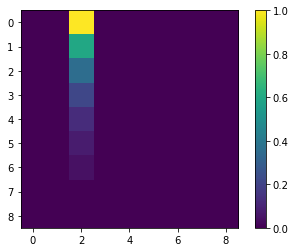

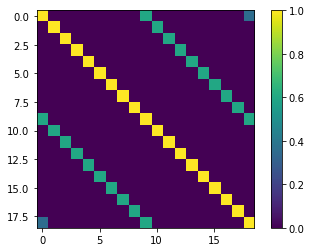

In [89]:
def build_covariance_y(variance, function, width=3):
    '''
    Generate a covariance matrix, which covariance is along the 
    y-dimension of a grid.

    Parameter
    ---------
    variance: array_like
        A 2D array of variances for each pixel.
    '''
    
    im_height, im_width = variance.shape
    n = im_height * im_width
    var = np.diagflat(variance.flatten())
    
    for p in range(n):
        idy = utils.get_neigbours_y(p, width, im_height, im_width)
        
        omega = np.arange(0,width+1)
        rho = function(omega, 1/np.log(width+1))
        
        top = 1
        bottom = min(width, p//im_width)
        for idx in idy:
            if p < idx:
                # bottom
                #var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                top += 1
            if p > idx:
            #    # top
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[bottom]
            #    var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * bottom
                bottom -= 1
            
    return var
            
var = np.ones((9,9))
Sigma = build_covariance_y(var, exponential, 6)

impulse = np.zeros((9,9))
impulse[0,2] = 1

response = np.reshape(Sigma @ impulse.flatten(), (9,9))

plt.imshow(response)
plt.colorbar()
plt.show()

plt.imshow(Sigma[:19,:19])
plt.colorbar()
plt.show()

#plt.plot(response[:,4])
#plt.show()